In [87]:
''' import libs '''
import numpy as np
import cv2
import copy
import math
from matplotlib import pyplot as plt

In [88]:
''' read the image '''
img = cv2.imread("monument.jpg")
h, w = img.shape[:2]

In [89]:
''' Use mouse to select the points for making the line 
    - Select five perpendicular pairs of lines
    - Each pairs will occupy 4 points
'''
NUM_POINTS = 20 # need 20 points to create five pair of lines

# the [x, y, 1] for each double left-click event will be stored here
points = list()

#this function will be called whenever the mouse is left-clicked
def mouse_callback(event, x, y, flags, params):
    # ref: https://stackoverflow.com/questions/32770654/get-pixel-location-using-mouse-click-events
    if event == cv2.EVENT_LBUTTONDBLCLK:
        global points, NUM_POINTS

        #store the coordinates of the right-click event
        points.append([float(x), float(y), 1.])
        print(f"Get {len(points)} / {NUM_POINTS}", points)


cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', int(w), int(h))

#set mouse callback function for window
cv2.setMouseCallback('image', mouse_callback)

cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

assert(len(points) == NUM_POINTS), "Need four points"

points = np.array(points)

Get 1 / 20 [[135.0, 440.0, 1.0]]
Get 2 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0]]
Get 3 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0], [225.0, 418.0, 1.0]]
Get 4 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0], [225.0, 418.0, 1.0], [220.0, 474.0, 1.0]]
Get 5 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0], [225.0, 418.0, 1.0], [220.0, 474.0, 1.0], [266.0, 420.0, 1.0]]
Get 6 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0], [225.0, 418.0, 1.0], [220.0, 474.0, 1.0], [266.0, 420.0, 1.0], [264.0, 473.0, 1.0]]
Get 7 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0], [225.0, 418.0, 1.0], [220.0, 474.0, 1.0], [266.0, 420.0, 1.0], [264.0, 473.0, 1.0], [264.0, 473.0, 1.0]]
Get 8 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0], [225.0, 418.0, 1.0], [220.0, 474.0, 1.0], [266.0, 420.0, 1.0], [264.0, 473.0, 1.0], [264.0, 473.0, 1.0], [341.0, 476.0, 1.0]]
Get 9 / 20 [[135.0, 440.0, 1.0], [304.0, 448.0, 1.0], [225.0, 418.0, 1.0], [220.0, 474.0, 1.0], [266.0, 420.0, 1.0], [264.0, 473.0, 1.0], [264.0, 47

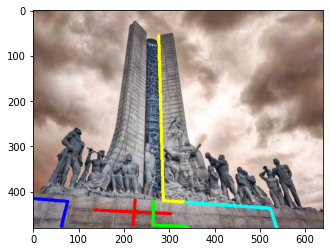

True

In [90]:
''' visualize the selected lines in pairs (same color) '''
plot_points = [(int(points[i, 0]), int(points[i, 1])) for i in range(NUM_POINTS)]
img_plot = copy.deepcopy(img)

# choose colors
color_array = np.zeros((5, 3))
color_array[0, 0] = 1
color_array[1, 1] = 1
color_array[2, 2] = 1
color_array[3, :2] = 1
color_array[4, 1:] = 1

# draw lines
for i in range(5):
    img_plot = cv2.line(img_plot, plot_points[4* i + 0], plot_points[4* i + 1],tuple(color_array[i] * 255),5)
    img_plot = cv2.line(img_plot, plot_points[4* i + 2], plot_points[4* i + 3],tuple(color_array[i] * 255),5)

plt.imshow(img_plot), plt.show()
cv2.imwrite("01_onestep_original_img.jpg", img)
cv2.imwrite("02_onestep_original_img_with_lines.jpg", img_plot)

In [91]:
''' Formulate the equations '''
l = list()
m = list()

for i in range(5):
    # form the lines from two points using cross products
    tmp_l = np.cross(points[4* i + 0], points[4 * i + 1])
    tmp_l = tmp_l / tmp_l[-1]
    l.append(tmp_l)
    
    tmp_m = np.cross(points[4* i + 2], points[4 * i + 3])
    tmp_m = tmp_m / tmp_m[-1]
    m.append(tmp_m)

# Ac = 0
A = np.empty((5, 6))
for i in range(5):
    A[i] = [l[i][0] * m[i][0], (l[i][0]*m[i][1] + l[i][1]*m[i][0]) / 2, l[i][1]*m[i][1], 
            (l[i][0]*m[i][2] + l[i][2]*m[i][0]) / 2, (l[i][1]*m[i][2] + l[i][2]*m[i][1]) / 2, l[i][2]*m[i][2]]

# print(A)

In [92]:
''' solve the equations using SCD decomposition '''
u, s, vh = np.linalg.svd(A)
ans = vh[-1]    # the answer of Ac=0  equation is the last row of vh (last col of v)

# formulate conics
C_star = np.matrix([[ans[0]    , ans[1] / 2, ans[3] / 2],
                    [ans[1] / 2, ans[2]    , ans[4] / 2],
                    [ans[3] / 2, ans[4] / 2, ans[5]    ]]) 
# print(C_star)

In [158]:
''' Get H from SVD decomposition of C_star '''
u, s, vh = np.linalg.svd(C_star)
H = u @ np.diag([s[0] ** 0.5, s[1] ** 0.5, 0.35])

print(H)

[[-8.72659772e-01 -4.85954299e-02  4.48199462e-04]
 [ 5.33827936e-02 -7.94379207e-01 -4.35116897e-04]
 [ 1.18386873e-03 -9.25336817e-04  3.49999443e-01]]


In [159]:
''' Rectrify the image '''

# check the transformed positions of the four corners of the image
corners = np.array([[0, 0, 1],
                    [0, w, 1],
                    [h, 0, 1],
                    [h, w, 1]])

transformed = np.linalg.inv(H) @ corners.T
transformed = transformed / transformed[-1]

print(transformed)
# form the translation matrix to bring the image back into the frame
tx = -np.min(transformed[0]) * 1
ty = -np.min(transformed[1]) * 1
M = np.float32([[1, 0, tx], [0, 1, ty/3], [0, 0, 1]])

print(M)

# rectrify the image
img_rect = cv2.warpPerspective(img, M.dot(np.linalg.inv(H)), (w, h))

[[ 5.42075086e-04  7.65533074e+01 -1.18783432e+02 -2.15074862e+02]
 [-5.11316775e-04 -1.37470836e+03 -7.98287077e+00 -3.58740647e+02]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
[[  1.        0.      215.07486]
 [  0.        1.      458.2361 ]
 [  0.        0.        1.     ]]


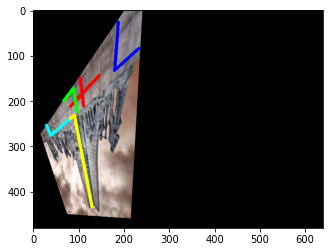

True

In [160]:
''' Visualize the rectrification result '''

# transform the chosen lines 
points_rect = M.dot(np.linalg.inv(H)) @ points.T
points_rect = points_rect / points_rect[-1]
points_rect = points_rect.T
plot_points_rect = [(int(points_rect[i, 0]), int(points_rect[i, 1])) for i in range(NUM_POINTS)]
img_rect_plot = copy.deepcopy(img_rect)

# plot the transformed lines 
for i in range(5):
    img_rect_plot = cv2.line(img_rect_plot, plot_points_rect[4* i + 0], plot_points_rect[4* i + 1],tuple(color_array[i] * 255),5)
    img_rect_plot = cv2.line(img_rect_plot, plot_points_rect[4* i + 2], plot_points_rect[4* i + 3],tuple(color_array[i] * 255),5)

plt.imshow(img_rect_plot), plt.show()
cv2.imwrite("03_onestep_img_rect_plot.jpg", img_rect)
cv2.imwrite("04_onestep_img_rect_plot_with_lines.jpg", img_rect_plot)